In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import os

In [2]:
root_directory = "Dataset/Brain Tumor MRI images/"
filepaths = []
labels = []

In [3]:
for dirpath, dirnames, filenames in os.walk(root_directory):

    label = os.path.basename(dirpath)

    if label in ['Healthy', 'Tumor']:
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            filepaths.append(filepath)
            labels.append(label)

In [4]:
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})
print(df.head())
print(f"\nFound {len(df)} images.")

                                            filepath    label
0  Dataset/Brain Tumor MRI images/Healthy/mri_hea...  Healthy
1  Dataset/Brain Tumor MRI images/Healthy/mri_hea...  Healthy
2  Dataset/Brain Tumor MRI images/Healthy/mri_hea...  Healthy
3  Dataset/Brain Tumor MRI images/Healthy/mri_hea...  Healthy
4  Dataset/Brain Tumor MRI images/Healthy/mri_hea...  Healthy

Found 5000 images.


In [5]:
IMG_SIZE = 224
# Transforms for the training data (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1), # Ensure images are 1-channel grayscale
    transforms.RandomHorizontalFlip(p=0.5),      # 50% chance of horizontal flip
    transforms.RandomRotation(degrees=15),       # Rotate between -15 and +15 degrees
    transforms.ToTensor(),                       # Convert to tensor and normalize to [0, 1]
])

# Transforms for the validation/test data (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [6]:
class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        # Create a mapping from string label to number
        self.label_map = {'Healthy': 0, 'Tumor': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['filepath']
        label_str = self.df.iloc[index]['label']

        image = Image.open(img_path).convert('L') # grayscale

        # Apply the transformations (resize, augment, normalize)
        if self.transform:
            image = self.transform(image)

        label = self.label_map[label_str]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [7]:
# Split the DataFrame (!Dataset)
df_train, df_val = train_test_split(df,
                                    test_size=0.2,
                                    random_state=42,
                                    stratify=df['label'])

# Dataset instances
train_dataset = MRIDataset(df=df_train, transform=train_transforms)
val_dataset = MRIDataset(df=df_val, transform=val_transforms)

# DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0) # change this when not in ipynb

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=0) # change this when not in ipynb

print(f"Created {len(train_dataset)} training samples and {len(val_dataset)} validation samples.")

Created 4000 training samples and 1000 validation samples.


In [8]:
# Get one batch of data
images, labels = next(iter(train_loader))

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Image batch shape: torch.Size([32, 1, 224, 224])
Label batch shape: torch.Size([32])


### PLOTS

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

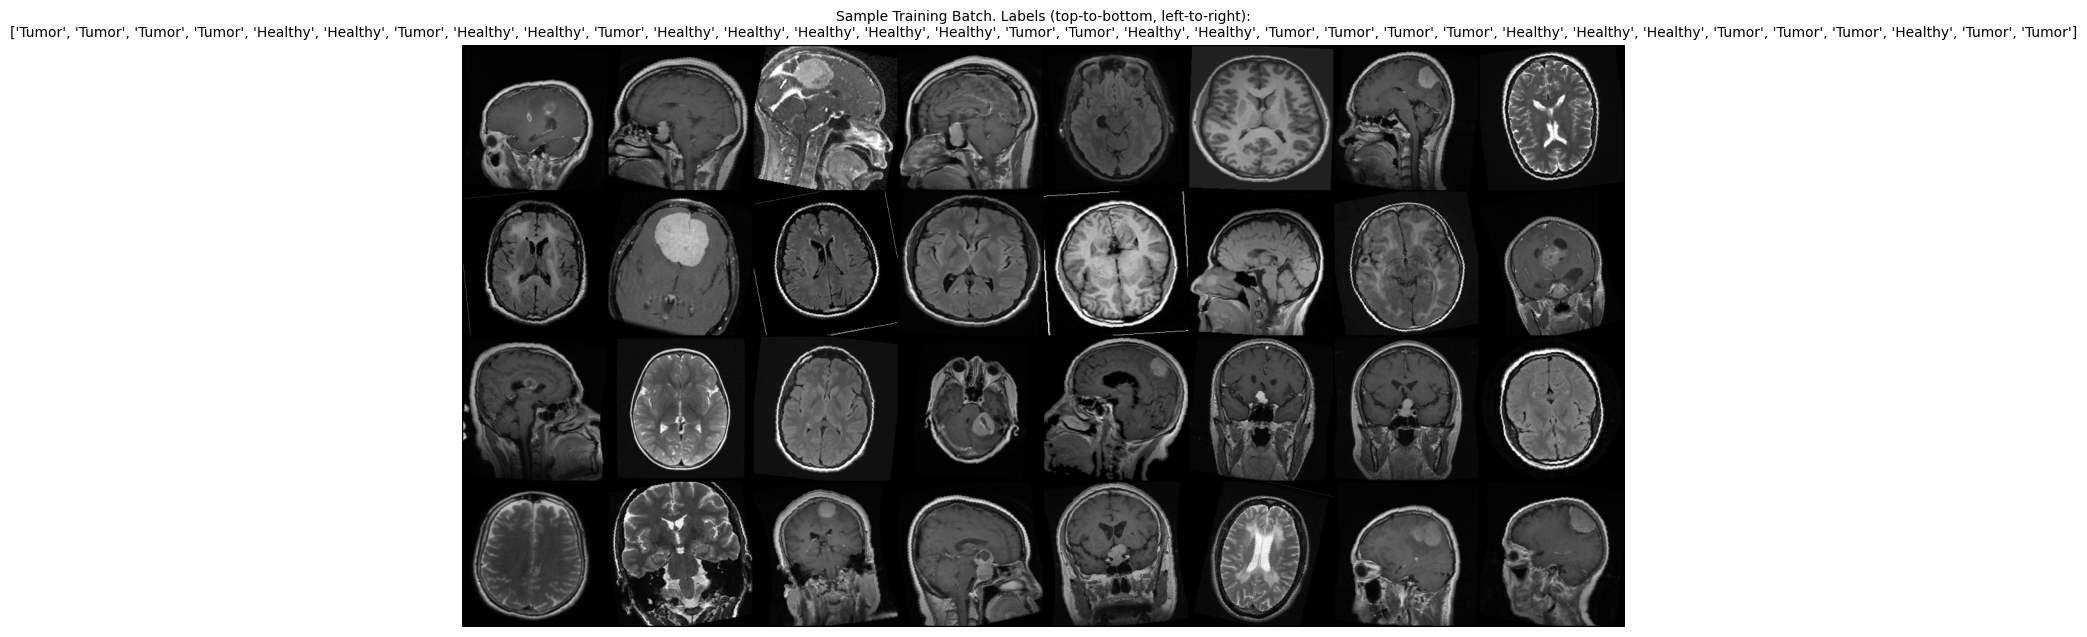

In [10]:
# Get one batch of training images
try:
    images, labels = next(iter(train_loader))
except StopIteration:
    print("DataLoader is empty or has been fully iterated.")

label_map = {0: 'Healthy', 1: 'Tumor'}

img_grid = torchvision.utils.make_grid(images, nrow=8)
np_img = img_grid.permute(1, 2, 0).numpy()

batch_labels = [label_map[label.item()] for label in labels]


plt.figure(figsize=(15, 10))
plt.imshow(np_img)
plt.title(f"Sample Training Batch. Labels (top-to-bottom, left-to-right):\n{batch_labels[:32]}",
          fontsize=10)
plt.axis('off')
plt.show()

### MODEL

In [11]:
from Model import CNN_MRI
import torch.nn as nn

In [12]:
dummy_mri_data = torch.randn(32, 1, 224, 224)
print("Initializing CNN_MRI model...")
model = CNN_MRI()
print("Running forward test...")
features = model(dummy_mri_data)
print(f"Output feature shape: {features.shape}")

Initializing CNN_MRI model...
Running forward test...
Output feature shape: torch.Size([32, 512])


In [13]:
# Your 'proxy head' is just a simple linear classifier.
# For your 'Healthy' vs 'Tumor' task, you need 2 output classes.
# Input dimension is 512 (from our model), output is 2.
proxy_head = nn.Linear(in_features=512, out_features=2)
final_output = proxy_head(features)
print(f"Proxy head output shape: {final_output.shape}")

Proxy head output shape: torch.Size([32, 2])
